# Electricity Monthly Demand Forecast
# ANN Try 1

## Packages

In [2]:
# psycopg2: python package to deal with a postgres database
# pip install psycopg2
import psycopg2
from psycopg2.extras import execute_values

In [3]:
import numpy as np
import pandas as pd
import warnings

import os

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore", category=Warning)
# Seteos de Pandas para ver mejor la info. https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
# In max_columns and max_rows ‘None’ value means unlimited.
pd.set_option('display.max_rows', 100)
# Conviene setear min_rows también porque cuando se superan las max_rows, sólo muestra la cantidad indicada en min_rows.
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.1f}'.format

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional

from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

from sklearn.svm import SVR

from tensorflow.keras import regularizers

In [5]:
path_data = r'C:\Users\Usuario\OneDrive\0-Data Science\data_science\energy_demand\data'

## Support Functions

In [6]:
def build_postgres_cnxn(database, host, user, password, port=5432, string_connection=None, verbose=True):
    error_txt = ''
    process_ok = True
    cnxn = None
    cursor = None
    if (not host or not user or not password) and not string_connection:
        process_ok = False
        error_txt = 'ERROR build_postgres_cnxn: Error trying to Build DB connexion: you missed to send host, user or password, or string connection. ' +\
                    ' host: ' + (host if host else 'Missed. ') +\
                    ' user: ' + (user if user else 'Missed.') +\
                    ' password: ' + (password if password else 'Missed.') +\
                    ' String Connection: ' + (string_connection if string_connection else 'Missed.')
        if verbose:
            print(error_txt)
    else:
        if not database:
            if verbose:
                print('WARNING build_postgres_cnxn: no database name provided.')
        try:
            if not string_connection:
                cnxn = psycopg2.connect(database=database, host=host, user=user, password=password, port=port)
            else:
                cnxn = psycopg2.connect(string_connection)
            cursor = cnxn.cursor()
            if verbose:
                print('INFO Module build_postgres_cnxn: DB Connection to host', host, 'Ok')
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            if not string_connection:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database host: ' + host + ' user ' +\
                      user + ' port: ' + str(port) +'\n' + txt)
            else:
                if verbose:
                    print('ERROR build_postgres_cnxn: Error connectig to database string_connection: ' + string_connection +'\n' + txt)
    return process_ok, error_txt, cnxn, cursor


In [7]:
def pg_select_to_pandas(cursor, sql_query, verbose=True):
    error_txt = ''
    process_ok = True
    df = pd.DataFrame()
    if (not cursor or not sql_query):
        process_ok = False
        error_txt = 'ERROR pg_select_to_pandas: No cursor or Query sent as parameter. ' +\
              ' cursor: ' + (' received.' if cursor else ' missed,') +\
              ' query: ' + (sql_query if sql_query else ' missed.')
        if verbose:
            print(error_txt)
    else:
        try:
            cursor.execute(sql_query)
            data = cursor.fetchall()
            colnames = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(data=data, columns=colnames)
            if verbose:
                print('INFO pg_select_to_pandas: query executed Ok. Number of records returned: ' + str(df.shape[0]))
        except Exception as err:
            process_ok = False
            formatted_lines = traceback.format_exc().splitlines()
            txt = ' '.join(formatted_lines)
            error_txt = 'ERROR pg_select_to_pandas: Error executing query on host: ' + cursor.connection.info.host + ' database ' +\
                  cursor.connection.info.dbname + ' query: ' + sql_query +'\n' + txt
            if verbose:
                print(error_txt)
    return process_ok, error_txt, df

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
#plot_event(df_hist, element, '2021-09-01', '2022-08-30', ['press_suc', 'press_1', 'press_2'], [], title=element
#    , xposition=[], yposition=[33.9, 89, 90], fig_size=[15, 5], return_df=False)

def plot_df(df_, time_since, time_until, time_col, left_feat_lst, right_feat_lst, title="", xposition=[], yposition=[]
    , fig_size=[10, 3], return_df=True, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None):
    """Plot a spot in a timeline
        PARAMS:
        df_: dataframe source of data (must have fields "ts")
        ts *: timestamp column in df_
        time_since *: ts start of period to plot
        time_until *: ts end of period to plot
        left_feat_lst *: list of dataframe features to plot using left axis
        right_feat_lst *: list of dataframe features to plot using right axis
        xposition: list of vertical lines to draw
        texts: list of [x, y, string] for function plt.text()
    """
    colors_lst=['deepskyblue', 'skyblue', 'steelblue', 'dodgerblue', 'indianred', 'firebrick', 'lightsalmon', 'darkorange', 'orange']
    if not right_feat_markers and right_feat_lst:
        right_feat_markers = ['--' for feat in right_feat_lst]
    if not left_feat_markers and left_feat_lst:
        left_feat_markers = ['--' for feat in left_feat_lst]
    fig, ax = plt.subplots()
    df_plot = df_[(df_[time_col].between(time_since, time_until))]
    for idx, feat in enumerate(left_feat_lst):
        df_plot.plot(x=time_col, y=feat, ax=ax, style='-', color=colors_lst[idx], figsize=(fig_size[0], fig_size[1]))
    i=idx+1
    for idx, feat in enumerate(right_feat_lst):
        df_plot.plot(x=time_col, y=feat, ax=ax, style=right_feat_markers[idx], color=colors_lst[i+idx], figsize=(fig_size[0], fig_size[1])
            , secondary_y=True, lw=1)
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    if texts:
        for text in texts:
            if len(text) >= 3:
                plt.text(text[0], text[1], text[2], c=text[3])
            else:
                plt.text(text[0], text[1], text[2])
    for xc in xposition:
        ax.axvline(x=xc, color='r', linestyle='--', lw=1);
    for yc in yposition:
        ax.axhline(y=yc, color='r', linestyle='--', lw=1);
    return df_plot if return_df else np.nan

# Data Load from DB

## Monthly Data

INFO Module build_postgres_cnxn: DB Connection to host localhost Ok
INFO pg_select_to_pandas: query executed Ok. Number of records returned: 129


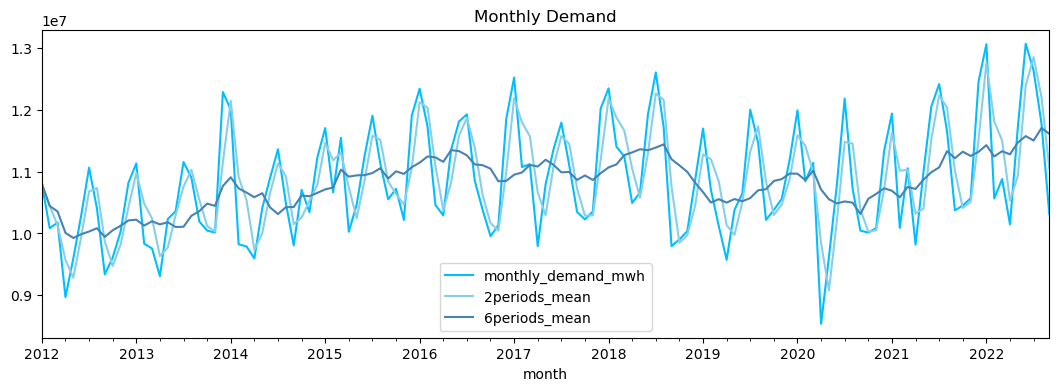

In [9]:
process_ok, error_txt, cnxn, cursor = build_postgres_cnxn(database='cammesa_db'
                                , host='localhost', user='postgres', password='postgres', port=5432, verbose=True)
if not process_ok:
    print(error_txt)
sql_query = """	select month
        	, sum(monthly_demand_mwh)	as monthly_demand_mwh
            from cammesa_db.monthly_demand
            group by month
            order by month
            """
process_ok, error_txt, df_monthly_demand = pg_select_to_pandas(cursor, sql_query, verbose=True)
df_monthly_demand.month = pd.to_datetime(df_monthly_demand.month)
cnxn.close()

df_mdemand = df_monthly_demand.copy()

df_roll = df_mdemand.copy()
if df_roll.index.name != 'month':
    df_roll.set_index('month', inplace=True)
df_roll['2periods_mean'] = df_roll['monthly_demand_mwh'].rolling(min_periods=1, window='60D').mean()
df_roll['6periods_mean'] = df_roll['monthly_demand_mwh'].rolling(min_periods=1, window='180D').mean()
df_roll.reset_index(inplace=True)

plot_df(df_roll, time_since='2012-01-01', time_until='2022-09-01', time_col='month'
    , left_feat_lst=['monthly_demand_mwh', '2periods_mean', '6periods_mean']
    , right_feat_lst=[]
    #, right_feat_lst=['rosario', 'ezeiza', 'sanfernando', 'aeroparque', 'corrientes', 'comrivadavia']
    , title="Monthly Demand", xposition=[], yposition=[]
    , fig_size=[13, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

indexedDataset = df_mdemand.copy()
if indexedDataset.index.name != 'month':
    indexedDataset.set_index('month', inplace=True)

# API de Series de Tiempo (Gob. Argentina)
https://series-tiempo-ar-api.readthedocs.io/es/latest/quick-start/

https://www.economia.gob.ar/datos/

In [66]:
# Estimador Mensual de Actividad Económica (EMAE). Base 2004
# Índice 2004=100
url = 'https://apis.datos.gob.ar/series/api/series?ids=143.3_NO_PR_2004_A_21&header=titles&collapse=month&collapse_aggregation=avg&start_date=2012-01-01&limit=1000&format=csv'

url = 'https://apis.datos.gob.ar/series/api/series?ids=bcra_17&header=titles&start_date=2012-01-01&limit=1000&format=csv' # Miles de pesos corrientes
url = 'https://apis.datos.gob.ar/series/api/series?ids=300.1_TIPO_CAMBIBIO_0_M_11&header=titles&start_date=2012-01-01&limit=1000&format=csv' # Miles de pesos
url = 'https://apis.datos.gob.ar/series/api/series?ids=bcra_1&header=titles&start_date=2012-01-01&limit=1000&format=csv' #Millones de USD
url = 'https://apis.datos.gob.ar/series/api/series?ids=143.3_NO_PR_2004_A_21,74.3_ISC_0_M_19,89.1_IR_BCRARIA_0_M_34,74.3_IET_0_M_16,142.3_TOTAL_2001_M_26&header=titles&start_date=2012-01-01&limit=1000&format=csv'
# ICA: Saldo comercial. En millones de dólares.
# Instrumentos del BCRA. Tasa de política monetaria
csv = pd.read_csv(url)
csv

,indice_tiempo,emae_original,ica_saldo_comercial,instr_bcra_tasa_politica_monetaria,ica_expo_totales,total_recursos_tributarios
0,2012-01-01,136.2,35.5,NaN,5399.3,52844.0
1,2012-02-01,132.4,1279.5,NaN,6004.5,47282.4
2,2012-03-01,147.4,1053.5,NaN,6200.0,48363.2
3,2012-04-01,145.5,1945.1,NaN,6715.0,49435.9
4,2012-05-01,157.4,1093.7,NaN,7080.8,61026.3
...,...,...,...,...,...,...
126,2022-07-01,151.3,-484.0,52.0,7805.0,1745178.1
127,2022-08-01,150.3,-296.0,64.4,7541.0,1731319.5
128,2022-09-01,147.5,381.0,71.9,7518.0,2127180.7
129,2022-10-01,NaN,1827.0,NaN,7901.0,1964056.4


In [89]:
# IPC. Nivel General Nacional. Base dic 2016. Mensual.
url = 'https://apis.datos.gob.ar/series/api/series?ids=145.3_INGNACNAL_DICI_M_15&header=titles&start_date=2012-01-01&limit=1000&format=csv' # 
csv = pd.read_csv(url)
csv[-15:]

,indice_tiempo,ipc_ng_nacional
56,2021-08-01,510.4
57,2021-09-01,528.5
58,2021-10-01,547.1
59,2021-11-01,560.9
60,2021-12-01,582.5
61,2022-01-01,605.0
62,2022-02-01,633.4
63,2022-03-01,676.1
64,2022-04-01,716.9
65,2022-05-01,753.1


In [93]:
url = 'https://apis.datos.gob.ar/series/api/series?ids=149.1_TL_INDIIOS_OCTU_0_21,150.1_CSTA_BATAL_0_D_20,150.1_LA_INDICIA_0_D_16,150.1_LA_POBREZA_0_D_13,50.3_ICS_0_M_12,57.1_SMVMM_0_M_34&header=titles&start_date=2012-01-01&end_date=2022-10-01&limit=1000&format=csv' # 
# Índice del Empleo total de la Encuesta de Indicadores Laborales 2001-08
csv = pd.read_csv(url)
csv[-10:]

,indice_tiempo,indice_salarios,canasta_basica_total,linea_indigencia,linea_pobreza,indice_total,salario_minimo_vital_movil_mensual
120,2022-01-01,506.7,25444.8,34333.8,78624.5,129.5,32000.0
121,2022-02-01,522.6,27122.1,37414.0,83807.3,129.9,33000.0
122,2022-03-01,561.2,29026.0,39862.4,89690.4,130.3,33000.0
123,2022-04-01,589.0,30828.6,42527.0,95260.4,130.4,38940.0
124,2022-05-01,625.6,32257.9,44498.6,99676.9,130.5,38940.0
125,2022-06-01,655.9,33727.1,46525.4,104216.8,131.0,45540.0
126,2022-07-01,692.3,36018.6,49465.6,111297.6,131.1,45540.0
127,2022-08-01,737.5,38756.3,52989.8,119756.9,131.3,47850.0
128,2022-09-01,787.1,41493.2,56731.9,128214.1,131.5,51200.0
129,2022-10-01,NaN,NaN,NaN,NaN,NaN,54550.0


In [75]:
url = 'https://apis.datos.gob.ar/series/api/series?ids=40.3_VT_0_M_17,41.3_CP_0_A_16,41.3_GN_0_A_11,41.3_GO_0_A_7,455.1_VENTAS_PRETES_0_M_25_98&header=titles&start_date=2012-01-01&limit=1000&format=csv' # 
# Tn, Millones de M3, Miles de M3,Ventas supermercados. Ventas a precios constantes
csv = pd.read_csv(url)
csv

,indice_tiempo,vacunos_toneladas,cemento_portland,gas_natural,gas_oil,ventas_precios_constantes
0,2012-01-01,215408.7,16531.0,3814.1,635.3,NaN
1,2012-02-01,202051.7,13833.0,3466.2,561.0,NaN
2,2012-03-01,218972.7,16092.0,3752.6,584.1,NaN
3,2012-04-01,195651.7,12856.0,3673.3,593.0,NaN
4,2012-05-01,225517.2,12869.0,3796.4,581.1,NaN
...,...,...,...,...,...,...
125,2022-06-01,266232.3,13232.6,4184.1,733.3,24144.4
126,2022-07-01,261372.0,15824.4,4345.9,746.5,26090.3
127,2022-08-01,289694.5,NaN,4386.3,776.4,23930.7
128,2022-09-01,278320.5,NaN,4082.3,734.6,23136.7


In [59]:
url = 'https://apis.datos.gob.ar/series/api/series?ids=300.1_AP_ACT_RESTER_0_M_21&header=titles&start_date=2012-01-01&limit=1000&format=csv' # Miles de Pesos
url = 'https://apis.datos.gob.ar/series/api/series?ids=bcra_246,366.3_POZOS_TERMRAL__30&header=titles&collapse=month&collapse_aggregation=avg&start_date=2012-01-01&limit=1000&format=csv' #Miles de USD corrientes
csv = pd.read_csv(url)
csv

,indice_tiempo,bcra_246,pozos_terminados_total_general
0,2012-01-01,46557428.6,88.0
1,2012-02-01,46795666.7,76.0
2,2012-03-01,47177772.7,105.0
3,2012-04-01,47468235.3,100.0
4,2012-05-01,47407285.7,116.0
...,...,...,...
124,2022-05-01,NaN,54.0
125,2022-06-01,NaN,83.0
126,2022-07-01,NaN,72.0
127,2022-08-01,NaN,55.0


In [25]:
# EMAE. Industria Manufacturera, EMAE. Agricultura, ganadería, caza y silvicultura, EMAE. Industria Manufacturera
url = 'https://apis.datos.gob.ar/series/api/series?ids=11.3_VMASD_2004_M_23,11.3_ISOM_2004_M_39,11.3_VMATC_2004_M_12&header=titles&start_date=2012-01-01&limit=1000&format=csv' # 
csv = pd.read_csv(url)
csv

,indice_tiempo,industria_manufacturera,agricultura_ganaderia_caza_silvicultura,construccion
0,2012-01-01,124.6,70.4,153.1
1,2012-02-01,123.6,68.4,152.8
2,2012-03-01,145.9,124.4,155.5
3,2012-04-01,138.2,166.1,149.3
4,2012-05-01,142.0,239.3,150.0
...,...,...,...,...
124,2022-05-01,135.8,272.2,137.5
125,2022-06-01,145.1,182.0,140.7
126,2022-07-01,137.9,114.9,135.5
127,2022-08-01,142.0,79.2,161.4


In [91]:
#
url = 'https://apis.datos.gob.ar/series/api/series?ids=302.2_ELEC_GAS_A_M3_0_M_33,302.2_ELEC_GAS_AGWH_0_M_35,302.2_SERV_TELEFS_U_0_M_38,302.2_TRANSP_PASSAJ_0_M_29&header=titles&start_date=2012-01-01&limit=1000&format=csv' # 
csv = pd.read_csv(url)
csv[-10:]

,indice_tiempo,elec_gas_agua_gas_naturalmiles_m3,elec_gas_agua_energia_electrica_gwh,serv_telef_fija_lineas_activas_miles_u,transp_pasaj_totalmiles_pasaj
32,2020-01-01,9853961.0,37168.3,23421.3,427564.5
33,2020-04-01,10187823.0,31404.1,23141.6,89562.6
34,2020-07-01,11424802.0,35822.8,22976.1,113337.5
35,2020-10-01,9406401.0,34255.0,22863.1,197130.0
36,2021-01-01,9164752.0,35603.6,22376.4,250156.3
37,2021-04-01,11117613.0,35544.6,22107.4,232996.3
38,2021-07-01,12705285.0,37245.9,21714.6,328408.1
39,2021-10-01,9656384.0,36465.3,21337.0,400255.7
40,2022-01-01,9523936.0,39209.3,21267.6,368709.3
41,2022-04-01,9128796.0,39223.0,23336.0,346079.0


In [92]:
url = 'https://apis.datos.gob.ar/series/api/series?ids=31.2_UNG_2004_T_18,323.1_E_ELECTRICDAD__45&header=titles&start_date=2012-01-01&limit=1000&format=csv' # 
csv = pd.read_csv(url)
csv[-10:]

,indice_tiempo,ucii_nivel_general,e_electricidad_gas_agua_imp_net_sub_actividad
16,2020-01-01,55.7,-103062.2
17,2020-04-01,47.2,-456939.5
18,2020-07-01,58.7,-499809.4
19,2020-10-01,61.2,-379049.3
20,2021-01-01,60.0,-318417.3
21,2021-04-01,63.3,-693605.9
22,2021-07-01,65.1,-999090.4
23,2021-10-01,66.0,-1003769.1
24,2022-01-01,63.1,-1110126.2
25,2022-04-01,68.3,-1234940.6


In [ ]:
econ = pd.read_csv(os.path.join(path_data, ''))

# ANN Try 1

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [81]:
df_mdemand.tail()

,month,monthly_demand_mwh
124,2022-05-01,11726718.0
125,2022-06-01,13073296.2
126,2022-07-01,12638511.3
127,2022-08-01,11781433.4
128,2022-09-01,10310019.9


In [83]:
#df_mdemand = df_monthly_demand.copy()
if df_mdemand.index.name != 'month':
    df_mdemand.set_index('month', inplace=True)

In [97]:
# Normalization: One reason this is important is because the features are multiplied by the model weights. 
# So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
mdemand_scaled = scaler.transform(df_mdemand) # Returns an array!!!
mdemand_scaled[-10:]

array([[0.86416303],
       [0.99836413],
       [0.44741644],
       [0.51655761],
       [0.35474728],
       [0.70314159],
       [1.        ],
       [0.90414997],
       [0.71520381],
       [0.39082497]])

In [96]:
# Reverse scaler:
scaler.inverse_transform(mdemand_scaled)[-10:]

array([[12457126.723     ],
       [13065875.77600001],
       [10566724.26900002],
       [10880355.21899999],
       [10146368.088     ],
       [11726718.04200001],
       [13073296.23900001],
       [12638511.32700002],
       [11781433.417     ],
       [10310019.91799999]])

In [16]:
def create_NN(input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(Dense(int(hidden_nodes), input_dim=int(input_nodes)))
    model.add(Dense(int(output_nodes)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [17]:
def train_model(model, X_train, y_train, epochs, batch_size):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)
    return model

## FNN
Feed Forward NN: the output(y_t) depends on the previous 'p' time steps. So, the output layer consists of one unit and input layer layer consists of p units.

In [109]:
def preprocess_FNN(data, look_back):
    data = np.array(data)[:, 0] # transforms the array of arrays len(1) (matrix) in an array
    X_train = []
    y_train = []
    for i in range(data.shape[0]-look_back): # does not include last "look_back" records
        x = data[i:look_back+i][::-1] # For each step, takes the last "look_back" timesteps and returns them backwards:
        y = data[look_back+i] # takes the n'th target
        X_train.append(list(x))
        y_train.append(y)
    # list[<start>:<stop>:<step>]: So, when you do a[::-1], it starts from the end towards the first taking each element. 
    # So it reverses a.
    input_seq_for_test = data[i+1:look_back+i+1][::-1] # the last "look_back" records
    return X_train, y_train, input_seq_for_test

In [18]:
def reshape_arrays(X_train, y_train):
    #X_train = np.array(X_train)
    if type(X_train) == list:
        X_train = np.array(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

In [142]:
def forecast_FNN(model, input_sequence, future_steps):
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence, verbose=0)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0] = np.append(forecasted_value, input_sequence[0][:-1]) # replaces current input_sequence starting with 
        # recently forecasted value and the rest of the sequence shifted 1 to the right (remember, the data is backwards)
        # and you add the last forecasted value at the beggining. This is the new window to forecast
    return forecasted_values

## FNN autorregresive

In [398]:
# FNN autorregresive
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)

data = scaler.transform(df_mdemand)

look_back = 24
hidden_nodes = 12
output_nodes = 1
future_steps = 6
epochs = 100
batch_size = 10

X_train, y_train, input_seq_for_test_FNN = preprocess_FNN(data, look_back)
X_train, y_train = reshape_arrays(X_train, y_train)
X_train.shape, y_train.shape

((105, 24), (105, 1))

nan

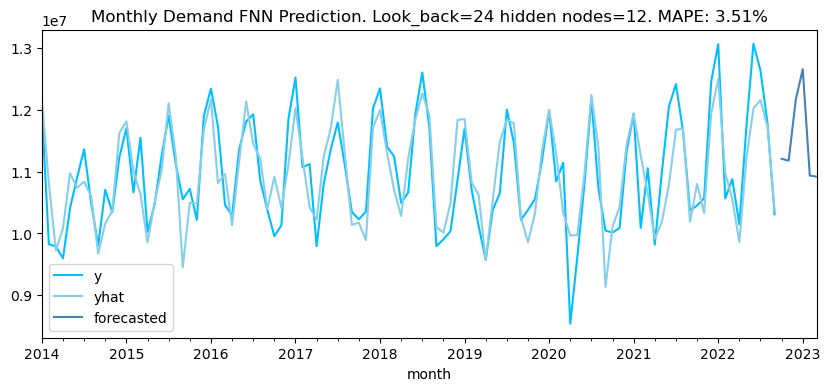

In [402]:
# FNN autorregresive
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)

data = scaler.transform(df_mdemand)

look_back = 24
hidden_nodes = 12
output_nodes = 1
future_steps = 6
epochs = 100
batch_size = 10

X_train, y_train, input_seq_for_test_FNN = preprocess_FNN(data, look_back)
X_train, y_train = reshape_arrays(X_train, y_train)
model_FNN = create_NN(input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes)
model_FNN = train_model(model_FNN, X_train, y_train, epochs=epochs, batch_size=batch_size)

input_seq_for_test_FNN = np.reshape(input_seq_for_test_FNN, (1, len(input_seq_for_test_FNN)))
forecasted_values_FNN = forecast_FNN(model_FNN, input_sequence=input_seq_for_test_FNN, future_steps=future_steps)
forecasted_values_FNN = list(scaler.inverse_transform([forecasted_values_FNN])[0])

# Calculate MAPE:
FNN_train_predicted = model_FNN.predict(X_train, verbose=0)
FNN_train_predicted = np.reshape(scaler.inverse_transform(FNN_train_predicted), (len(FNN_train_predicted)))

df_ = pd.DataFrame()
df_['y'] = np.reshape(scaler.inverse_transform(y_train), (len(y_train)))
df_['yhat'] = FNN_train_predicted

df_.index = df_mdemand.index[look_back:]
df_.reset_index(inplace=True)
MAPE_FNN = mean_absolute_percentage_error(df_.y, df_.yhat) * 100

# Build dataframe for plotting
ftr =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
ftr.columns = ['month']
ftr.reset_index(drop=True, inplace=True)
lst = ([None]*df_.shape[0])
lst.extend(forecasted_values_FNN)
ftr['forecasted'] = lst

# Plot
df_plot=ftr.merge(df_, on='month', how='left')
plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['y', 'yhat', 'forecasted']
    , right_feat_lst=[]
    , title="Monthly Demand FNN Prediction. Look_back=" + str(look_back) + " hidden nodes=" + str(hidden_nodes) + ". MAPE: " +\
        str(round(MAPE_FNN, 2)) + '%', xposition=[], yposition=[]
    , fig_size=[10, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

### FNN 5 Fold Cross Validation

In [243]:
# Cross Validation
n_crossvals = 5
# Model
look_back = 24
hidden_nodes = 12
output_nodes = 1
epochs = 100
batch_size = 1
#future_steps = 6
tscv = TimeSeriesSplit(n_splits=n_crossvals)
# initalize lists to capture the output
predictions = []
actuals = []

X, y, input_seq_for_test_FNN = preprocess_FNN(data, look_back)
X, y = reshape_arrays(X, y)

#run the model on each of the time series splits
for train, test in tscv.split(X, y):
        
    #initalize the model
    model_FNN = create_NN(input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    #fit the model
    model_FNN = train_model(model_FNN, X[train], y[train], epochs=epochs, batch_size=batch_size)
        
    #make predictions
    FNN_test_predicted = model_FNN.predict(X[test], verbose=0)
    FNN_test_predicted = np.reshape(scaler.inverse_transform(FNN_test_predicted), (len(FNN_test_predicted)))

    #save the results in a list
    predictions.append(FNN_test_predicted)
    actual = scaler.inverse_transform(y[test].copy())
    print('MAPE K-Fold', round(mean_absolute_percentage_error(actual, FNN_test_predicted) * 100, 2), '%')
    actuals.append(actual)
        
predictions = np.array(predictions)
actuals = np.array(actuals)
mape = 0
for idx in range(len(predictions)):
    mape = mape + mean_absolute_percentage_error(actuals[idx], predictions[idx]) * 100
print('MAPE k-fold:', round(mape / len(predictions), 2), '%')


MAPE K-Fold 4.64 %
MAPE K-Fold 4.46 %
MAPE K-Fold 4.63 %
MAPE K-Fold 5.86 %
MAPE K-Fold 3.89 %
MAPE k-fold: 4.7 %


### FNN Hyper parameters Grid Search

In [269]:
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)

data = scaler.transform(df_mdemand)

n_crossvals = 5
# Model
#look_back_lst = [6, 12, 18, 24, 36]
look_back_lst = [6, 12, 18, 24, 36]
hidden_nodes_lst = [3, 6, 12, 18, 24]
output_nodes = 1
epochs_lst = [10, 100, 200]
batch_size_lst = [1, 10, 50]
#future_steps = 6

tscv = TimeSeriesSplit(n_splits=n_crossvals)

best_score, best_cfg = float("inf"), None
#run the model on each of the time series splits
for look_back in look_back_lst:
    for hidden_nodes in [h for h in hidden_nodes_lst if h <= look_back]:
        for epochs in epochs_lst:
            for batch_size in batch_size_lst:

                X, y, input_seq_for_test_FNN = preprocess_FNN(data, look_back)
                X, y = reshape_arrays(X, y)

                cfg = (look_back, hidden_nodes, output_nodes, epochs, batch_size)
                print('***Config', cfg)
                mape = 0
                for train, test in tscv.split(X, y):
                    #initalize the model
                    model_FNN = create_NN(input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes)
                    #fit the model
                    model_FNN = train_model(model_FNN, X[train], y[train], epochs=epochs, batch_size=batch_size)
                        
                    #make predictions
                    FNN_test_predicted = model_FNN.predict(X[test], verbose=0)
                    FNN_test_predicted = np.reshape(scaler.inverse_transform(FNN_test_predicted), (len(FNN_test_predicted)))

                    actual = scaler.inverse_transform(y[test].copy())
                    mape = mape + round(mean_absolute_percentage_error(actual, FNN_test_predicted) * 100, 2)

                MAPE = round(mape / n_crossvals, 2)
                print('FNN ', cfg, ' MAPE= ', MAPE, '%')
                if MAPE < best_score:
                    best_score, best_cfg = MAPE, cfg
                    print('FNN ', cfg, ' MAPE= ', MAPE, '%<---- Best Score so far')
print('----------------------------------------------------')
print(print('FNN ', best_cfg, ' MAPE= ', best_score, '%<---- FINAL Best Score'))
# FNN  (12, 12, 1, 100, 1)  MAPE=  4.05 %<---- Best Score so far
# 40 min!! FNN  (12, 24, 1, 200, 10)  MAPE=  3.72 %<---- FINAL Best Score
# 94 min°° (18, 3, 1, 200, 1)  MAPE=  3.8 %<---- FINAL Best Score

***Config (6, 3, 1, 10, 1)
FNN  (6, 3, 1, 10, 1)  MAPE=  6.44 %
FNN  (6, 3, 1, 10, 1)  MAPE=  6.44 %<---- Best Score so far
***Config (6, 3, 1, 10, 10)
FNN  (6, 3, 1, 10, 10)  MAPE=  19.85 %
***Config (6, 3, 1, 10, 50)
FNN  (6, 3, 1, 10, 50)  MAPE=  36.93 %
***Config (6, 3, 1, 100, 1)
FNN  (6, 3, 1, 100, 1)  MAPE=  4.3 %
FNN  (6, 3, 1, 100, 1)  MAPE=  4.3 %<---- Best Score so far
***Config (6, 3, 1, 100, 10)
FNN  (6, 3, 1, 100, 10)  MAPE=  6.02 %
***Config (6, 3, 1, 100, 50)
FNN  (6, 3, 1, 100, 50)  MAPE=  9.23 %
***Config (6, 3, 1, 200, 1)
FNN  (6, 3, 1, 200, 1)  MAPE=  4.39 %
***Config (6, 3, 1, 200, 10)
FNN  (6, 3, 1, 200, 10)  MAPE=  6.21 %
***Config (6, 3, 1, 200, 50)
FNN  (6, 3, 1, 200, 50)  MAPE=  5.9 %
***Config (6, 6, 1, 10, 1)
FNN  (6, 6, 1, 10, 1)  MAPE=  8.01 %
***Config (6, 6, 1, 10, 10)
FNN  (6, 6, 1, 10, 10)  MAPE=  13.72 %
***Config (6, 6, 1, 10, 50)
FNN  (6, 6, 1, 10, 50)  MAPE=  15.65 %
***Config (6, 6, 1, 100, 1)
FNN  (6, 6, 1, 100, 1)  MAPE=  4.32 %
***Config (6, 6,

# Timed Lagged NN Autorregresive

### Support Functions

#### This does not work correctly
Because it does not bring the same month of years before

In [74]:
def preprocess_TLNN(data, look_back, extra_lag=False, long_lag_step=12, max_step=60, idx=0, multivar=False, col_var=0):
    """
    https://www.kaggle.com/code/nicholasjhana/univariate-time-series-forecasting-with-keras/notebook
    look_back - is the number of consecutive past steps from the target month to construct
    long_lag_step - is the size of the trailing lag beyond the look_back. Ie. if look_back is 12, and long_lag_step is 12 
    will return months -1, -2, -3,...-12, -24, -36, -48 etc to max_step=60
    idx - is the starting index for the first slice
    multivari - true if the input data has multiple variable structure. false for univariate (NOT tested yet)
    """
    #if not adding extra lag features adjust max_step and look_back to aling
    if not extra_lag:
        max_step=look_back
        look_back+=1
    
    X, y = list(), list()
    for i in range(idx, len(data)):
        # find the end of this pattern
        end_ix = i + max_step
        # check if we are beyond the dataset
        if end_ix > len(data)-1:
            break

        #create a list with the indexes we want to include in each sample
        #slices = [x for x in range(end_ix-1,end_ix-look_back, -1)] + [y for y in range(end_ix-look_back, i, -long_lag_step)]
        #slices = [x for x in range(end_ix,end_ix-look_back, -1)] + [y for y in range(end_ix-look_back, i, -long_lag_step)]
        #slices = [x for x in range(end_ix-1,end_ix-look_back-1, -1)] + [y for y in range(end_ix-look_back-1, i, -long_lag_step)]
        slices = [x for x in range(end_ix-1,end_ix-look_back-1, -1)] + [y for y in range(end_ix-long_lag_step-1, i, -long_lag_step)]
        #reverse the slice indexes
        slices = list(reversed(slices))
        if i == 0:
            print('1', slices)
        # gather input and output parts of the pattern
        seq_x = data[slices, :]
        seq_y = data[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)
    if multivar:
        #unstack the 3rd dimension and select the first element(energy load)
        y = y[:, col_var]
    
    return X, y, slices
#X, y = preprocess_TLNN(data, look_back=look_back, extra_lag=True, long_lag_step=long_lag_step, max_step=max_step
#    , idx=0, multivar=False, col_var=0)
#X, y = reshape_arrays(X, y)
#X.shape, y.shape

In [90]:
def forecast_TLNN(model, data, look_back, extra_lag=False, long_lag_step=12, max_step=60, future_steps=1):
    forecasted_values = []
    for idx in range(future_steps):
        i = len(data) -1 + idx - max_step
        end_ix = len(data) -1 + idx

        #if end_ix > len(data)-1:
        #    break
        #create a list with the indexes we want to include in each sample
        slices = [x for x in range(end_ix-1,end_ix-look_back-1, -1)] + [y for y in range(end_ix-long_lag_step-1, i, -long_lag_step)]
        #reverse the slice indexes
        slices = list(reversed(slices))

        print(slices)
        # gather input and output parts of the pattern
        input_sequence = data[slices, :]
        input_sequence = np.reshape(input_sequence, (1, input_sequence.shape[0]))

        forecasted_value = model.predict(input_sequence, verbose=0)
        forecasted_values.append(forecasted_value[0][0])
        
        data = np.append(data, forecasted_value, axis=0)
        print(len(data))
    return forecasted_values

#forecasted = forecast_TLNN(model_TLNN, data, look_back=look_back, extra_lag=True, long_lag_step=long_lag_step, max_step=max_step
#    , future_steps=future_steps)
#forecasted

#### These work

In [199]:
def preprocess_TLNN_back(data, look_back, extra_lag=False, long_lag_step=12, max_step=60, idx=0, multivar=False, col_var=0):
    """
    https://www.kaggle.com/code/nicholasjhana/univariate-time-series-forecasting-with-keras/notebook
    look_back - is the number of consecutive past steps from the target month to construct
    long_lag_step - is the size of the trailing lag beyond the look_back. Ie. if look_back is 12, and long_lag_step is 12 
    will return months -1, -2, -3,...-12, -24, -36, -48 etc to max_step=60
    idx - is the starting index for the first slice
    multivari - true if the input data has multiple variable structure. false for univariate (NOT tested yet)
    """
    #if not adding extra lag features adjust max_step and look_back to aling
    if not extra_lag:
        max_step=look_back
        look_back+=1
    
    # Option backwards
    X, y = list(), list()
    for i in range(len(data)-1, idx, -1):
        # find the end of this pattern
        end_ix = i - max_step
        # check if we are outside the dataset
        if end_ix < 0:
            break
        look_back_slice = [x for x in range(i-1, i-1-look_back, -1)]
        #long_lag_slice = [y for y in range(i-look_back, i-1-max_step, -long_lag_step)]
        long_lag_slice = [y for y in range(i-((int(look_back/long_lag_step)+1)*long_lag_step), i-1-max_step, -long_lag_step)]
        slices = list(set(look_back_slice + long_lag_slice))
        
        #slices = list(reversed(slices))
        slices.sort(reverse=True)
        #slices.sort()
        # gather input and output parts of the pattern
        seq_x = data[slices, :]
        #seq_y = data[end_ix, :] 
        seq_y = data[i, :] 
        X.append(seq_x)
        y.append(seq_y)
        
    # Reverse order, because we are processing the original data backwards
    X = np.array(X)[::-1]
    #X = X[::-1]
    y = np.array(y)[::-1]
    #y = y[::-1]
    if multivar:
        #unstack the 3rd dimension and select the first element(energy load)
        y = y[:, col_var]
    
    return X, y, slices, look_back_slice, long_lag_slice
X, y, slices, look_back_slice, long_lag_slice = preprocess_TLNN_back(data, look_back=look_back, extra_lag=True, long_lag_step=long_lag_step, max_step=max_step
    , idx=0, multivar=False, col_var=0)

In [174]:
look_back, long_lag_step, max_step

(6, 12, 24)

In [176]:
df_monthly_demand[df_monthly_demand.index.isin(long_lag_slice)]

,month,monthly_demand_mwh
0,2012-01-01,10804699.8
12,2013-01-01,11134119.3


In [200]:
def forecast_TLNN_back(model, data, look_back, extra_lag=False, long_lag_step=12, max_step=60, future_steps=1):
    forecasted_values = []
    for idx in range(0, future_steps, 1):
        i = len(data)
        #print('data:', len(data), 'idx:', idx, 'i:', i)
        end_ix = i - max_step
        #create a list with the indexes we want to include in each sample
        # check if we are outside the dataset
        if end_ix < 0:
            break
        look_back_slice = [x for x in range(i-1, i-1-look_back, -1)]
        #long_lag_slice = [y for y in range(i-look_back, i-1-max_step, -long_lag_step)]
        #long_lag_slice = [y for y in range(i-int(look_back/long_lag_step)*long_lag_step, i-1-max_step, -long_lag_step)]
        long_lag_slice = [y for y in range(i-((int(look_back/long_lag_step)+1)*long_lag_step), i-1-max_step, -long_lag_step)]
        slices = list(set(look_back_slice + long_lag_slice))
        slices.sort(reverse=True)
        #slices.sort()
        #print(i, slices)

        # gather input and output parts of the pattern
        input_sequence = data[slices, :]
        input_sequence = np.reshape(input_sequence, (1, input_sequence.shape[0]))

        forecasted_value = model.predict(input_sequence, verbose=0)
        forecasted_values.append(forecasted_value[0][0])
        
        data = np.append(data, forecasted_value, axis=0)
    return forecasted_values

#forecasted = forecast_TLNN(model_TLNN, data, look_back=look_back, extra_lag=True, long_lag_step=long_lag_step, max_step=max_step
#    , future_steps=future_steps)
#forecasted

### Unitary Test

In [58]:
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

nan

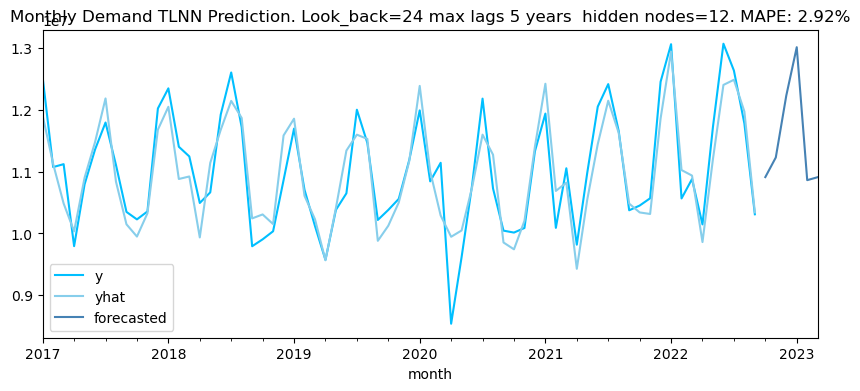

In [203]:
# Model
look_back = 24  # 1 year
long_lag_step = 12 # lags every 1 year, the same month
max_step = 60 # 2 years
hidden_nodes = 12
output_nodes = 1
epochs = 1000 # 2000 ~ 1:20 m
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
extra_lag = True
future_steps = 6

#X, y, slices = preprocess_TLNN(data, look_back=look_back, extra_lag=True, long_lag_step=long_lag_step, max_step=max_step
#    , idx=0, multivar=False, col_var=0)
X, y, slices, look_back_slice, long_lag_slice = preprocess_TLNN_back(data, look_back=look_back, extra_lag=True
            , long_lag_step=long_lag_step, max_step=max_step, idx=0, multivar=False, col_var=0)
X_train, y_train = reshape_arrays(X, y)
input_nodes = look_back + (max_step - ((int(look_back/long_lag_step))*long_lag_step))/long_lag_step
#model_TLNN = create_NN(input_nodes=int(look_back+(max_step-look_back)/long_lag_step), hidden_nodes=hidden_nodes
model_TLNN = create_NN(input_nodes=input_nodes, hidden_nodes=hidden_nodes
    , output_nodes=output_nodes)
model_TLNN = train_model(model_TLNN, X_train, y_train, epochs=epochs, batch_size=batch_size)

# Calculate MAPE:
TLNN_train_predicted = model_TLNN.predict(X_train, verbose=0)
TLNN_train_predicted = np.reshape(scaler.inverse_transform(TLNN_train_predicted), (len(TLNN_train_predicted)))

df_ = pd.DataFrame()
df_['y'] = np.reshape(scaler.inverse_transform(y_train), (len(y_train)))
df_['yhat'] = TLNN_train_predicted

df_.index = df_mdemand.index[max_step:]
df_.reset_index(inplace=True)
MAPE_TLNN = mean_absolute_percentage_error(df_.y, df_.yhat) * 100

#forecasted_values_TLNN = forecast_TLNN(model_TLNN, data, look_back=look_back, extra_lag=True, long_lag_step=long_lag_step
#                                    , max_step=max_step, future_steps=future_steps)
forecasted_values_TLNN = forecast_TLNN_back(model_TLNN, data, look_back=look_back, extra_lag=True, long_lag_step=long_lag_step, max_step=max_step
    , future_steps=future_steps)
forecasted_values_TLNN = list(scaler.inverse_transform([forecasted_values_TLNN])[0])

# Build dataframe for plotting
ftr =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
ftr.columns = ['month']
ftr.reset_index(drop=True, inplace=True)
lst = ([None]*df_.shape[0])
lst.extend(forecasted_values_TLNN)
ftr['forecasted'] = lst

# Plot
df_plot=ftr.merge(df_, on='month', how='left')
plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['y', 'yhat', 'forecasted']
    , right_feat_lst=[]
    , title="Monthly Demand TLNN Prediction. Look_back=" + str(look_back) + " max lags " + str(int(max_step/12)) + " years " +\
         " hidden nodes=" + str(hidden_nodes) + ". MAPE: " +\
        str(round(MAPE_TLNN, 2)) + '%', xposition=[], yposition=[]
    , fig_size=[10, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [184]:
df_monthly_demand[df_monthly_demand.index.isin(slices)]

,month,monthly_demand_mwh
0,2012-01-01,10804699.8
12,2013-01-01,11134119.3
18,2013-07-01,11156173.4
19,2013-08-01,10904479.2
20,2013-09-01,10195873.0
21,2013-10-01,10045715.6
22,2013-11-01,10015701.7
23,2013-12-01,12291286.5


In [ ]:
#plt.figure(figsize=(7, 3))
#plt.plot(model_TLNN.history.epoch, model_TLNN.history.history["loss"], 'g', label='Training loss')
#plt.title('Training loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()


In [148]:
df_plot['dif'] = ((df_plot.yhat-df_plot.y) / df_plot.y)*100
df_plot[-30:]

,month,forecasted,y,yhat,dif
69,2020-10-01,NaN,10013844.0,9605602.0,-4.1
70,2020-11-01,NaN,10087844.5,10116395.0,0.3
71,2020-12-01,NaN,11330177.6,11551181.0,2.0
72,2021-01-01,NaN,11941581.0,12311220.0,3.1
73,2021-02-01,NaN,10090389.3,11190179.0,10.9
74,2021-03-01,NaN,11055214.5,10710030.0,-3.1
75,2021-04-01,NaN,9817737.9,9587765.0,-2.3
76,2021-05-01,NaN,10986114.1,10432359.0,-5.0
77,2021-06-01,NaN,12053804.3,11372636.0,-5.7
78,2021-07-01,NaN,12418960.4,12253801.0,-1.3


### 5 Fold Cross Validation

In [560]:
# Cross Validation - PENDING
# Model
look_back = 12  # 1 year
long_lag_step = 12 # lags every 1 year, the same month
max_step = 60 # 2 years
hidden_nodes = 3
output_nodes = 1
epochs = 1000 # 2000 ~ 1:20 m
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
extra_lag = True

df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)

data = scaler.transform(df_mdemand)

n_crossvals = 5
tscv = TimeSeriesSplit(n_splits=n_crossvals)
# initalize lists to capture the output
predictions = []
actuals = []

X, y, slices = preprocess_TLNN(data, look_back=look_back, extra_lag=True, long_lag_step=long_lag_step, max_step=max_step
    , idx=0, multivar=False, col_var=0)
X, y = reshape_arrays(X, y)

print("Monthly Demand TLNN Prediction. Look_back=" + str(look_back) + " max lags " + str(int(max_step/12)) + " years " +\
         " hidden nodes=" + str(hidden_nodes) + " epochs: " + str(epochs))
#run the model on each of the time series splits
k_fold = 0
for train, test in tscv.split(X, y):
    #initalize the model
    model_TLNN = create_NN(input_nodes=int(look_back+(max_step-look_back)/look_back), hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    #fit the model
    model_TLNN = train_model(model_TLNN, X[train], y[train], epochs=epochs, batch_size=batch_size)
    
    #make predictions
    TLNN_test_predicted = model_TLNN.predict(X[test], verbose=0)
    TLNN_test_predicted = np.reshape(scaler.inverse_transform(TLNN_test_predicted), (len(TLNN_test_predicted)))

    #save the results in a list
    predictions.append(TLNN_test_predicted)
    actual = scaler.inverse_transform(y[test].copy())
    print('MAPE Parcial K-Fold [', k_fold, ']:', round(mean_absolute_percentage_error(actual.flatten(), TLNN_test_predicted.flatten()) * 100, 2), '%')
    actuals.append(actual)
    k_fold+=1
        
predictions = np.array(predictions)
actuals = np.array(actuals)
mape = mean_absolute_percentage_error(actuals.flatten(), predictions.flatten()) * 100
print('MAPE K-fold:', round(mape, 2), '%')

Monthly Demand TLNN Prediction. Look_back=12 max lags 5 years  hidden nodes=3 epochs: 1000
MAPE Parcial K-Fold [ 0 ]: 4.5 %
MAPE Parcial K-Fold [ 1 ]: 4.98 %
MAPE Parcial K-Fold [ 2 ]: 5.29 %
MAPE Parcial K-Fold [ 3 ]: 4.92 %
MAPE Parcial K-Fold [ 4 ]: 4.34 %
MAPE K-fold: 4.8 %


### Grid Search

In [194]:
# Grid Search
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# Hyperparameters
#look_back_lst = [6, 12, 24]
look_back_lst = [6, 12, 24]
max_step_lst = [24, 36, 48, 60]
long_lag_step = 12 # lags every 1 year, the same month
hidden_nodes_lst = [6, 12]
output_nodes = 1
epochs_lst = [500, 1000]
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
extra_lag = True

best_score, best_cfg = float("inf"), None
for look_back in look_back_lst:
    for max_step in [m for m in max_step_lst if m > look_back]:
        input_nodes = look_back + (max_step - ((int(look_back/long_lag_step))*long_lag_step))/long_lag_step
        for hidden_nodes in [h for h in hidden_nodes_lst if h <= input_nodes]:
            for epochs in epochs_lst:
                cfg = (input_nodes, look_back, max_step, hidden_nodes, epochs)
                print('***Config [input_nodes, look_back, max_step, hidden_nodes, epochs]', cfg)
                X, y, slices, look_back_slice, long_lag_slice = preprocess_TLNN_back(data, look_back=look_back, extra_lag=True
                            , long_lag_step=long_lag_step, max_step=max_step, idx=0, multivar=False, col_var=0)
                X_train, y_train = reshape_arrays(X, y)
                model_TLNN = create_NN(input_nodes=input_nodes, hidden_nodes=hidden_nodes, output_nodes=output_nodes)
                model_TLNN = train_model(model_TLNN, X_train, y_train, epochs=epochs, batch_size=batch_size)

                # Calculate MAPE:
                TLNN_train_predicted = model_TLNN.predict(X_train, verbose=0)
                TLNN_train_predicted = np.reshape(scaler.inverse_transform(TLNN_train_predicted), (len(TLNN_train_predicted)))

                df_ = pd.DataFrame()
                df_['y'] = np.reshape(scaler.inverse_transform(y_train), (len(y_train)))
                df_['yhat'] = TLNN_train_predicted

                df_.index = df_mdemand.index[max_step:]
                df_.reset_index(inplace=True)
                MAPE_TLNN = round(mean_absolute_percentage_error(df_.y, df_.yhat) * 100, 2)
                print('TLNN ', cfg, ' MAPE= ', MAPE_TLNN, '%')
                if MAPE_TLNN < best_score:
                    best_score, best_cfg = MAPE_TLNN, cfg
                    print('TLNN ', cfg, ' MAPE= ', MAPE_TLNN, '%<---- Best Score so far')
print('----------------------------------------------------')
print('TLNN ', best_cfg, ' MAPE= ', best_score, '%<---- FINAL Best Score')
# ***Config [look_back, hidden_nodes, max_step/long_lag_step, epochs]
# TLNN  (24, 12, 60, 3, 500)  MAPE=  3.0 %<---- FINAL Best Score

#***Config [input_nodes, look_back, max_step, hidden_nodes, epochs]
#TLNN  (27.0, 24, 60, 12, 1000)  MAPE=  2.93 %<---- FINAL Best Score

***Config [input_nodes, look_back, max_step, hidden_nodes, epochs] (8.0, 6, 24, 6, 500)
TLNN  (8.0, 6, 24, 6, 500)  MAPE=  3.63 %
TLNN  (8.0, 6, 24, 6, 500)  MAPE=  3.63 %<---- Best Score so far
***Config [input_nodes, look_back, max_step, hidden_nodes, epochs] (8.0, 6, 24, 6, 1000)
TLNN  (8.0, 6, 24, 6, 1000)  MAPE=  3.59 %
TLNN  (8.0, 6, 24, 6, 1000)  MAPE=  3.59 %<---- Best Score so far
***Config [input_nodes, look_back, max_step, hidden_nodes, epochs] (9.0, 6, 36, 6, 500)
TLNN  (9.0, 6, 36, 6, 500)  MAPE=  3.98 %
***Config [input_nodes, look_back, max_step, hidden_nodes, epochs] (9.0, 6, 36, 6, 1000)
TLNN  (9.0, 6, 36, 6, 1000)  MAPE=  3.73 %
***Config [input_nodes, look_back, max_step, hidden_nodes, epochs] (10.0, 6, 48, 6, 500)
TLNN  (10.0, 6, 48, 6, 500)  MAPE=  4.1 %
***Config [input_nodes, look_back, max_step, hidden_nodes, epochs] (10.0, 6, 48, 6, 1000)
TLNN  (10.0, 6, 48, 6, 1000)  MAPE=  3.58 %
TLNN  (10.0, 6, 48, 6, 1000)  MAPE=  3.58 %<---- Best Score so far
***Config [in

# LSTM

In [215]:
def preprocess_LSTM(data, look_back):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data.shape[0]-look_back):
        slice = [j for j in range(i,look_back+i)][::-1]
        x = data[i:look_back+i][::-1]
        y = data[look_back+i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = data[i+1:look_back+i+1][::-1]
    return X_train, y_train, input_seq_for_test, slice

### Vanilla LSTM
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

#### Unitary Test

nan

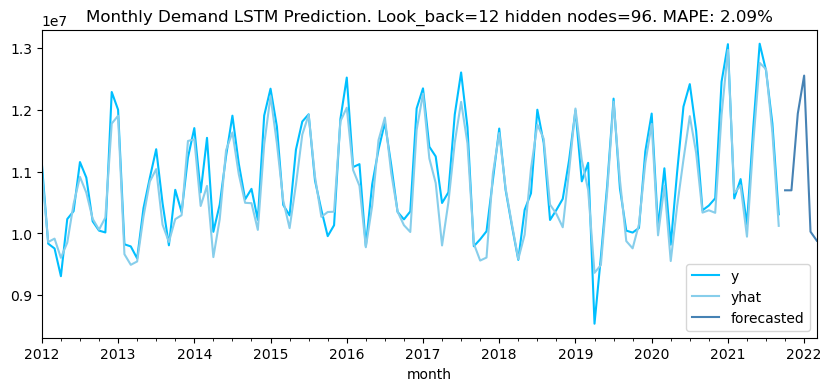

In [333]:
# Data
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# Model
n_features = 1 # Univariate forcasting
look_back = 12  # 1 year
hidden_nodes = 96
output_nodes = 1
epochs = 1000 # 2000 ~ 1:20 m
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
future_steps = 6

X, y, input_seq_for_test, slice = preprocess_LSTM(data, look_back=look_back)
df_monthly_demand[df_monthly_demand.index.isin(slice)]
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = np.array(X)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
y_train = np.array(y)

# Create LSTM
model = Sequential()
model.add(LSTM(hidden_nodes, activation='relu', input_shape=(look_back, n_features)))
model.add(Dense(output_nodes))
# Adam version of stochastic gradient descent
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Calculate MAPE:
LSTM_predicted = model.predict(X, verbose=0) # shape (117, 1)
LSTM_predicted = np.reshape(scaler.inverse_transform(LSTM_predicted), (len(LSTM_predicted)))

df_ = pd.DataFrame()
df_['y'] = np.reshape(scaler.inverse_transform(np.reshape(y_train, (1, len(y_train)))), (len(y_train)))
df_['yhat'] = LSTM_predicted
df_.index = df_mdemand.index[:df_mdemand.shape[0]-look_back]
df_.reset_index(inplace=True)
MAPE_TLNN = mean_absolute_percentage_error(df_.y, df_.yhat) * 100

# forecast next 6 months
forecasted_values = []
for idx in range(0, future_steps, 1):
    i = len(data)
    slice = [j for j in range(i-look_back,i)]
    # gather input and output parts of the pattern
    input_sequence = data[slice, :][::-1]
    input_sequence = np.reshape(input_sequence, (input_sequence.shape[1], input_sequence.shape[0], n_features))
    
    forecasted_value = model.predict(input_sequence, verbose=0)
    forecasted_values.append(forecasted_value[0][0])
        
    data = np.append(data, forecasted_value, axis=0)

forecasted_values = list(scaler.inverse_transform([forecasted_values])[0])

# Build dataframe for plotting
ftr =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
ftr.columns = ['month']
ftr.reset_index(drop=True, inplace=True)
lst = ([None]*df_.shape[0])
lst.extend(forecasted_values)
ftr['forecasted'] = lst

# Plot
df_plot=ftr.merge(df_, on='month', how='left')
plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['y', 'yhat', 'forecasted']
    , right_feat_lst=[]
    , title="Monthly Demand LSTM Prediction. Look_back=" + str(look_back) + " hidden nodes=" + str(hidden_nodes) + ". MAPE: " +\
        str(round(MAPE_TLNN, 2)) + '%', xposition=[], yposition=[]
    , fig_size=[10, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

#### Cross Validation

In [299]:
# Data
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# Model
n_features = 1 # Univariate forcasting
look_back = 12  # 1 year
hidden_nodes = 96
output_nodes = 1
epochs = 1000 # 2000 ~ 1:20 m
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.

X, y, input_seq_for_test, slice = preprocess_LSTM(data, look_back=look_back)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = np.array(X)
X = np.reshape(X, (X.shape[0], X.shape[1], n_features))
y = np.array(y)

# Create LSTM
model = Sequential()
model.add(LSTM(hidden_nodes, activation='relu', input_shape=(look_back, n_features)))
model.add(Dense(output_nodes))
# Adam version of stochastic gradient descent
model.compile(loss='mean_squared_error', optimizer='adam')

# Cross Validation
#run the model on each of the time series splits
n_crossvals = 5
max_test_size = 6
print("Monthly Demand LSTM Prediction. Look_back=" + str(look_back) + " hidden nodes=" + str(hidden_nodes) +\
    " epochs: " + str(epochs) + " max test size=" + str(max_test_size))
# Used to limit the size of the test set. Defaults to n_samples // (n_splits + 1), which is the maximum allowed
tscv = TimeSeriesSplit(n_splits=n_crossvals, test_size=max_test_size)
# initalize lists to capture the output
predictions = []
actuals = []
k_fold = 0
for train, test in tscv.split(X, y):
    #fit the model
    model.fit(X[train], y[train], epochs=epochs, verbose=0)
    
    #make predictions
    test_predicted = model.predict(X[test], verbose=0)
    test_predicted = np.reshape(scaler.inverse_transform(test_predicted), (len(test_predicted)))

    #save the results in a list
    predictions.append(test_predicted)
    #actual = scaler.inverse_transform(y[test].copy())
    actual = np.reshape(scaler.inverse_transform(np.reshape(y[test], (1, len(y[test])))), (len(y[test])))
    print('MAPE Parcial K-Fold [', k_fold, ']:', round(mean_absolute_percentage_error(actual.flatten()
                                                    , test_predicted.flatten()) * 100, 2), '%')
    actuals.append(actual)
    k_fold+=1
        
predictions = np.array(predictions)
actuals = np.array(actuals)
mape = mean_absolute_percentage_error(actuals.flatten(), predictions.flatten()) * 100
print('MAPE K-fold:', round(mape, 2), '%')

Monthly Demand LSTM Prediction. Look_back=12 hidden nodes=96 epochs: 1000
MAPE Parcial K-Fold [ 0 ]: 7.01 %
MAPE Parcial K-Fold [ 1 ]: 4.83 %
MAPE Parcial K-Fold [ 2 ]: 7.05 %
MAPE Parcial K-Fold [ 3 ]: 4.69 %
MAPE Parcial K-Fold [ 4 ]: 2.6 %
MAPE K-fold: 5.23 %


### Stacked LSTM
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

#### Unitary Test

nan

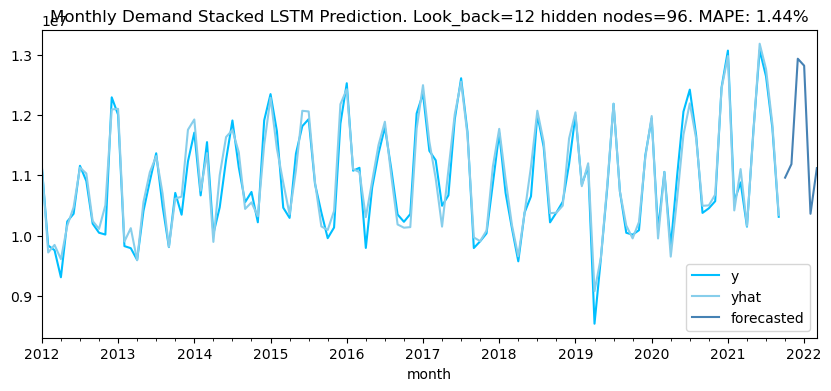

In [403]:
# Data
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# Model
n_features = 1 # Univariate forcasting
look_back = 12  # 1 year
hidden_nodes = 96
output_nodes = 1
epochs = 1000 # 2000 ~ 1:20 m
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
future_steps = 6

X, y, input_seq_for_test, slice = preprocess_LSTM(data, look_back=look_back)
df_monthly_demand[df_monthly_demand.index.isin(slice)]
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = np.array(X)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
y_train = np.array(y)

# Create LSTM
model = Sequential()
model.add(LSTM(hidden_nodes, activation='relu', return_sequences=True, input_shape=(look_back, n_features)))
model.add(LSTM(int(hidden_nodes/2), activation='relu', input_shape=(look_back, n_features)))
model.add(Dense(output_nodes))
# Adam version of stochastic gradient descent
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Calculate MAPE:
LSTM_predicted = model.predict(X, verbose=0) # shape (117, 1)
LSTM_predicted = np.reshape(scaler.inverse_transform(LSTM_predicted), (len(LSTM_predicted)))

df_ = pd.DataFrame()
df_['y'] = np.reshape(scaler.inverse_transform(np.reshape(y_train, (1, len(y_train)))), (len(y_train)))
df_['yhat'] = LSTM_predicted
df_.index = df_mdemand.index[:df_mdemand.shape[0]-look_back]
df_.reset_index(inplace=True)
MAPE_LSTM = mean_absolute_percentage_error(df_.y, df_.yhat) * 100

# forecast next 6 months
forecasted_values = []
for idx in range(0, future_steps, 1):
    i = len(data)
    slice = [j for j in range(i-look_back,i)]
    # gather input and output parts of the pattern
    input_sequence = data[slice, :][::-1]
    input_sequence = np.reshape(input_sequence, (input_sequence.shape[1], input_sequence.shape[0], n_features))
    
    forecasted_value = model.predict(input_sequence, verbose=0)
    forecasted_values.append(forecasted_value[0][0])
        
    data = np.append(data, forecasted_value, axis=0)

forecasted_values = list(scaler.inverse_transform([forecasted_values])[0])

# Build dataframe for plotting
ftr =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
ftr.columns = ['month']
ftr.reset_index(drop=True, inplace=True)
lst = ([None]*df_.shape[0])
lst.extend(forecasted_values)
ftr['forecasted'] = lst

# Plot
df_plot=ftr.merge(df_, on='month', how='left')
plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['y', 'yhat', 'forecasted']
    , right_feat_lst=[]
    , title="Monthly Demand Stacked LSTM Prediction. Look_back=" + str(look_back) + " hidden nodes=" + str(hidden_nodes) + ". MAPE: " +\
        str(round(MAPE_LSTM, 2)) + '%', xposition=[], yposition=[]
    , fig_size=[10, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

#### Cross Validation

In [405]:
# Data
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# Model
# Model
n_features = 1 # Univariate forcasting
look_back = 12  # 1 year
hidden_nodes = 96
output_nodes = 1
epochs = 1000 # 2000 ~ 1:20 m
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.

X, y, input_seq_for_test, slice = preprocess_LSTM(data, look_back=look_back)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = np.array(X)
X = np.reshape(X, (X.shape[0], X.shape[1], n_features))
y = np.array(y)

# Create LSTM
model = Sequential()
model.add(LSTM(hidden_nodes, activation='relu', return_sequences=True, input_shape=(look_back, n_features)))
model.add(LSTM(int(hidden_nodes/2), activation='relu', input_shape=(look_back, n_features)))
model.add(Dense(output_nodes))
# Adam version of stochastic gradient descent
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Cross Validation
#run the model on each of the time series splits
n_crossvals = 5
max_test_size = 12
# Used to limit the size of the test set. Defaults to n_samples // (n_splits + 1), which is the maximum allowed
tscv = TimeSeriesSplit(n_splits=n_crossvals, test_size=max_test_size)

print("Monthly Demand Stacked LSTM Prediction. Look_back=" + str(look_back) + " hidden nodes=" + str(hidden_nodes) +\
        " epochs: " + str(epochs) + " max test size=" + str(max_test_size))

# initalize lists to capture the output
predictions = []
actuals = []
k_fold = 0
for train, test in tscv.split(X, y):
    #fit the model
    model.fit(X[train], y[train], epochs=epochs, verbose=0)
    
    #make predictions
    test_predicted = model.predict(X[test], verbose=0)
    test_predicted = np.reshape(scaler.inverse_transform(test_predicted), (len(test_predicted)))

    #save the results in a list
    predictions.append(test_predicted)
    #actual = scaler.inverse_transform(y[test].copy())
    actual = np.reshape(scaler.inverse_transform(np.reshape(y[test], (1, len(y[test])))), (len(y[test])))
    print('MAPE Parcial K-Fold [', k_fold, ']:', round(mean_absolute_percentage_error(actual.flatten()
                                                    , test_predicted.flatten()) * 100, 2), '%')
    actuals.append(actual)
    k_fold+=1
        
predictions = np.array(predictions)
actuals = np.array(actuals)
mape = mean_absolute_percentage_error(actuals.flatten(), predictions.flatten()) * 100
print('MAPE K-fold:', round(mape, 2), '%')

Monthly Demand Stacked LSTM Prediction. Look_back=12 hidden nodes=96 epochs: 1000 max test size=12
MAPE Parcial K-Fold [ 0 ]: 2.7 %
MAPE Parcial K-Fold [ 1 ]: 2.34 %
MAPE Parcial K-Fold [ 2 ]: 4.23 %
MAPE Parcial K-Fold [ 3 ]: 4.61 %
MAPE Parcial K-Fold [ 4 ]: 3.18 %
MAPE K-fold: 3.41 %


### Bidirectional LSTM
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Has very poor predictions!! Cross validation gives good results, but when you use the values forecasted for the future to forecast more future, no converge.

#### Unitary Test

nan

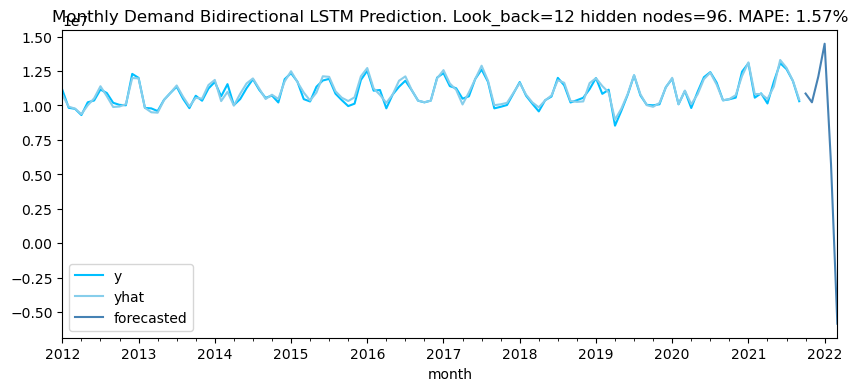

In [356]:
# Data
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# Model
n_features = 1 # Univariate forcasting
look_back = 12  # 1 year
hidden_nodes = 96
output_nodes = 1
epochs = 1000 # 2000 ~ 1:20 m
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
future_steps = 6

X, y, input_seq_for_test, slice = preprocess_LSTM(data, look_back=look_back)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = np.array(X)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
y_train = np.array(y)

# Create LSTM
model = Sequential()
model.add(Bidirectional(LSTM(hidden_nodes, activation='relu'), input_shape=(look_back, n_features)))
model.add(Dense(output_nodes))
# Adam version of stochastic gradient descent
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Calculate MAPE:
LSTM_predicted = model.predict(X, verbose=0) # shape (117, 1)
LSTM_predicted = np.reshape(scaler.inverse_transform(LSTM_predicted), (len(LSTM_predicted)))

df_ = pd.DataFrame()
df_['y'] = np.reshape(scaler.inverse_transform(np.reshape(y_train, (1, len(y_train)))), (len(y_train)))
df_['yhat'] = LSTM_predicted
df_.index = df_mdemand.index[:df_mdemand.shape[0]-look_back]
df_.reset_index(inplace=True)
MAPE_LSTM_2 = mean_absolute_percentage_error(df_.y, df_.yhat) * 100

# forecast next 6 months
forecasted_values = []
for idx in range(0, future_steps, 1):
    i = len(data)
    slice = [j for j in range(i-look_back,i)]
    # gather input and output parts of the pattern
    input_sequence = data[slice, :][::-1]
    #[samples, timestamps, features]
    input_sequence = np.reshape(input_sequence, (input_sequence.shape[1], input_sequence.shape[0], n_features))
    
    forecasted_value = model.predict(input_sequence, verbose=0)
    forecasted_values.append(forecasted_value[0][0])
        
    data = np.append(data, forecasted_value, axis=0)

forecasted_values = list(scaler.inverse_transform([forecasted_values])[0])

# Build dataframe for plotting
ftr =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
ftr.columns = ['month']
ftr.reset_index(drop=True, inplace=True)
lst = ([None]*df_.shape[0])
lst.extend(forecasted_values)
ftr['forecasted'] = lst

# Plot
df_plot=ftr.merge(df_, on='month', how='left')
plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['y', 'yhat', 'forecasted']
    , right_feat_lst=[]
    , title="Monthly Demand Bidirectional LSTM Prediction. Look_back=" + str(look_back) + " hidden nodes=" + str(hidden_nodes) + ". MAPE: " +\
        str(round(MAPE_LSTM_2, 2)) + '%', xposition=[], yposition=[]
    , fig_size=[10, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

In [ ]:
idx = 0
i = len(data)

nan

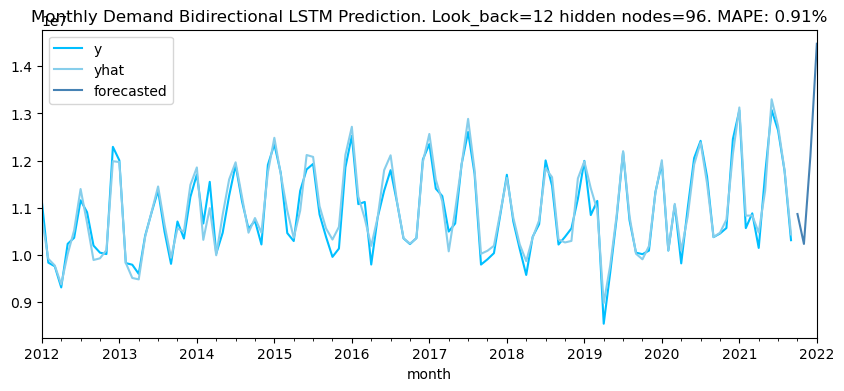

In [371]:
data = scaler.transform(df_mdemand)
future_steps=4

forecasted_values = []
for idx in range(0, future_steps, 1):
    i = len(data)
    slice = [j for j in range(i-look_back,i)]
    # gather input and output parts of the pattern
    input_sequence = data[slice, :][::-1]
    #print(slice)
    input_sequence = np.reshape(input_sequence, (input_sequence.shape[1], input_sequence.shape[0], n_features))
    
    forecasted_value = model.predict(input_sequence, verbose=0)
    forecasted_values.append(forecasted_value[0][0])
        
    data = np.append(data, forecasted_value, axis=0)

forecasted_values = list(scaler.inverse_transform([forecasted_values])[0])

# Build dataframe for plotting
ftr =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
ftr.columns = ['month']
ftr.reset_index(drop=True, inplace=True)
lst = ([None]*df_.shape[0])
lst.extend(forecasted_values)
ftr['forecasted'] = lst

# Plot
df_plot=ftr.merge(df_, on='month', how='left')
plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['y', 'yhat', 'forecasted']
    , right_feat_lst=[]
    , title="Monthly Demand Bidirectional LSTM Prediction. Look_back=" + str(look_back) + " hidden nodes=" + str(hidden_nodes) + ". MAPE: " +\
        str(round(MAPE_TLNN, 2)) + '%', xposition=[], yposition=[]
    , fig_size=[10, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)


In [372]:
df_plot[-16:]

,month,forecasted,y,yhat
105,2020-10-01,NaN,10451324.2,10467845.0
106,2020-11-01,NaN,10569433.8,10746484.0
107,2020-12-01,NaN,12457126.7,12142788.0
108,2021-01-01,NaN,13065875.8,13127424.0
109,2021-02-01,NaN,10566724.3,10830908.0
110,2021-03-01,NaN,10880355.2,10833125.0
111,2021-04-01,NaN,10146368.1,10472213.0
112,2021-05-01,NaN,11726718.0,11364549.0
113,2021-06-01,NaN,13073296.2,13300817.0
114,2021-07-01,NaN,12638511.3,12729647.0


In [345]:
X_train.shape

(117, 12, 1)

#### Cross Validation

In [315]:
# Data
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# Model
# Model
n_features = 1 # Univariate forcasting
look_back = 12  # 1 year
hidden_nodes = 96
output_nodes = 1
epochs = 1000 # 2000 ~ 1:20 m
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.

X, y, input_seq_for_test, slice = preprocess_LSTM(data, look_back=look_back)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = np.array(X)
X = np.reshape(X, (X.shape[0], X.shape[1], n_features))
y = np.array(y)

# Create LSTM
model = Sequential()
model.add(Bidirectional(LSTM(hidden_nodes, activation='relu'), input_shape=(look_back, n_features)))
model.add(Dense(output_nodes))
# Adam version of stochastic gradient descent
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Cross Validation
#run the model on each of the time series splits
n_crossvals = 5
max_test_size = 12
# Used to limit the size of the test set. Defaults to n_samples // (n_splits + 1), which is the maximum allowed
tscv = TimeSeriesSplit(n_splits=n_crossvals, test_size=max_test_size)

print("Monthly Demand Bidirectional LSTM Prediction. Look_back=" + str(look_back) + " hidden nodes=" + str(hidden_nodes) +\
        " epochs: " + str(epochs) + " max test size=" + str(max_test_size))

# initalize lists to capture the output
predictions = []
actuals = []
k_fold = 0
for train, test in tscv.split(X, y):
    #fit the model
    model.fit(X[train], y[train], epochs=epochs, verbose=0)
    
    #make predictions
    test_predicted = model.predict(X[test], verbose=0)
    test_predicted = np.reshape(scaler.inverse_transform(test_predicted), (len(test_predicted)))

    #save the results in a list
    predictions.append(test_predicted)
    #actual = scaler.inverse_transform(y[test].copy())
    actual = np.reshape(scaler.inverse_transform(np.reshape(y[test], (1, len(y[test])))), (len(y[test])))
    print('MAPE Parcial K-Fold [', k_fold, ']:', round(mean_absolute_percentage_error(actual.flatten()
                                                    , test_predicted.flatten()) * 100, 2), '%')
    actuals.append(actual)
    k_fold+=1
        
predictions = np.array(predictions)
actuals = np.array(actuals)
mape = mean_absolute_percentage_error(actuals.flatten(), predictions.flatten()) * 100
print('MAPE K-fold:', round(mape, 2), '%')

Monthly Demand Bidirectional LSTM Prediction. Look_back=12 hidden nodes=96 epochs: 1000 max test size=12
MAPE Parcial K-Fold [ 0 ]: 3.6 %
MAPE Parcial K-Fold [ 1 ]: 4.07 %
MAPE Parcial K-Fold [ 2 ]: 5.5 %
MAPE Parcial K-Fold [ 3 ]: 3.73 %
MAPE Parcial K-Fold [ 4 ]: 4.6 %
MAPE K-fold: 4.3 %


## CNN Convolutional Neuron Networks
https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

Best Practices: https://machinelearningmastery.com/crash-course-convolutional-neural-networks/

Number of Filters: Filters are the feature detectors. Generally, fewer filters are used at the input layer, and increasingly more filters are used at deeper layers.

#### Unitary Test

nan

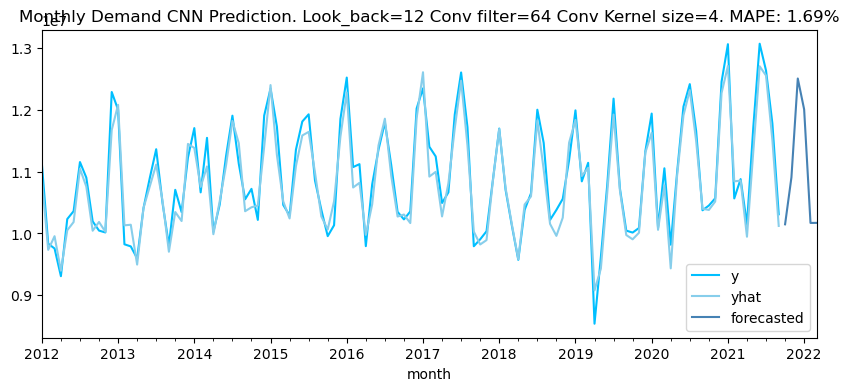

In [401]:
# Data
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# Model
n_features = 1 # Univariate forcasting
look_back = 12  # 1 year
conv_filter = 64 # number of features to extract 96 - 64 - Best practice: less filter at the input, more in deeper layers.
conv_kernel_size = 4 #dimensions of the convolution window.
hidden_nodes = 48 #48
output_nodes = 1
epochs = 1000
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
future_steps = 6

X, y, input_seq_for_test, slice = preprocess_LSTM(data, look_back=look_back)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = np.array(X)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
y_train = np.array(y)

# Create CNN
# input_shape describes the shape of each sample, that's why it should be (look_back, n_features)
model = Sequential()
model.add(Conv1D(filters=conv_filter, kernel_size=conv_kernel_size, activation='relu', input_shape=(look_back, n_features)
                , kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=hidden_nodes, activation='relu'))
model.add(Dense(output_nodes))
# Adam version of stochastic gradient descent
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Calculate MAPE:
CNN_predicted = model.predict(X_train, verbose=0)
CNN_predicted = np.reshape(scaler.inverse_transform(CNN_predicted), (len(CNN_predicted)))

df_ = pd.DataFrame()
df_['y'] = np.reshape(scaler.inverse_transform(np.reshape(y_train, (1, len(y_train)))), (len(y_train)))
df_['yhat'] = CNN_predicted
df_.index = df_mdemand.index[:df_mdemand.shape[0]-look_back]
df_.reset_index(inplace=True)
MAPE_CNN = mean_absolute_percentage_error(df_.y, df_.yhat) * 100

# forecast next "future_steps" months
forecasted_values = []
for idx in range(0, future_steps, 1):
    i = len(data)
    slice = [j for j in range(i-look_back,i)]
    # gather input and output parts of the pattern
    input_sequence = data[slice, :][::-1]
    input_sequence = np.reshape(input_sequence, (input_sequence.shape[1], input_sequence.shape[0], n_features))
    
    forecasted_value = model.predict(input_sequence, verbose=0)
    forecasted_values.append(forecasted_value[0][0])
        
    data = np.append(data, forecasted_value, axis=0)

forecasted_values = list(scaler.inverse_transform([forecasted_values])[0])

# Build dataframe for plotting
ftr =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
ftr.columns = ['month']
ftr.reset_index(drop=True, inplace=True)
lst = ([None]*df_.shape[0])
lst.extend(forecasted_values)
ftr['forecasted'] = lst

# Plot
df_plot=ftr.merge(df_, on='month', how='left')
plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['y', 'yhat', 'forecasted']
    , right_feat_lst=[]
    , title="Monthly Demand CNN Prediction. Look_back=" + str(look_back) + " Conv filter=" + str(conv_filter) +\
        " Conv Kernel size=" + str(conv_kernel_size) + ". MAPE: " +\
        str(round(MAPE_CNN, 2)) + '%', xposition=[], yposition=[]
    , fig_size=[10, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

#### Cross Validation

In [400]:
# Data
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# Model
n_features = 1 # Univariate forcasting
look_back = 12  # 1 year
conv_filter = 64
conv_kernel_size = 4 #dimensions of the convolution window.
hidden_nodes = 48
output_nodes = 1
epochs = 1000 # 2000 ~ 1:20 m
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.

X, y, input_seq_for_test, slice = preprocess_LSTM(data, look_back=look_back)
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = np.array(X)
X = np.reshape(X, (X.shape[0], X.shape[1], n_features))
y = np.array(y)

# Create LSTM
model = Sequential()
model.add(Conv1D(filters=conv_filter, kernel_size=conv_kernel_size, activation='relu', input_shape=(look_back, n_features)
    , kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=hidden_nodes, activation='relu'))
model.add(Dense(output_nodes))
# Adam version of stochastic gradient descent
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=epochs, verbose=0)

# Cross Validation
#run the model on each of the time series splits
n_crossvals = 5
max_test_size = 12
print("Monthly Demand LSTM Prediction. Look_back=" + str(look_back) + " Conv filter=" + str(conv_filter) +\
        " Conv Kernel size=" + str(conv_kernel_size) +\
        " epochs: " + str(epochs) + " max test size=" + str(max_test_size))
# Used to limit the size of the test set. Defaults to n_samples // (n_splits + 1), which is the maximum allowed
tscv = TimeSeriesSplit(n_splits=n_crossvals, test_size=max_test_size)
# initalize lists to capture the output
predictions = []
actuals = []
k_fold = 0
for train, test in tscv.split(X, y):
    #fit the model
    model.fit(X[train], y[train], epochs=epochs, verbose=0)
    
    #make predictions
    test_predicted = model.predict(X[test], verbose=0)
    test_predicted = np.reshape(scaler.inverse_transform(test_predicted), (len(test_predicted)))

    #save the results in a list
    predictions.append(test_predicted)
    #actual = scaler.inverse_transform(y[test].copy())
    actual = np.reshape(scaler.inverse_transform(np.reshape(y[test], (1, len(y[test])))), (len(y[test])))
    print('MAPE Parcial K-Fold [', k_fold, ']:', round(mean_absolute_percentage_error(actual.flatten()
                                                    , test_predicted.flatten()) * 100, 2), '%')
    actuals.append(actual)
    k_fold+=1
        
predictions = np.array(predictions)
actuals = np.array(actuals)
mape = mean_absolute_percentage_error(actuals.flatten(), predictions.flatten()) * 100
print('MAPE K-fold:', round(mape, 2), '%')

Monthly Demand LSTM Prediction. Look_back=12 Conv filter=64 Conv Kernel size=4 epochs: 1000 max test size=12
MAPE Parcial K-Fold [ 0 ]: 2.86 %
MAPE Parcial K-Fold [ 1 ]: 2.44 %
MAPE Parcial K-Fold [ 2 ]: 4.83 %
MAPE Parcial K-Fold [ 3 ]: 5.54 %
MAPE Parcial K-Fold [ 4 ]: 4.81 %
MAPE K-fold: 4.1 %


### CNN LSTM
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

I could not make it work... :(

#### Unitary Test

In [471]:
# Data
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# Model
n_features = 1 # Univariate forcasting
look_back = 12  # 1 year
conv_filter = 64 # number of features to extract
conv_kernel_size = 4 #dimensions of the convolution window.
n_steps = 2
hidden_nodes = 48 #48
output_nodes = 1
epochs = 1000
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
future_steps = 6

X, y, input_seq_for_test, slice = preprocess_LSTM(data, look_back=look_back)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
X_train = np.array(X)
X_train = np.reshape(X_train, (X_train.shape[0], int(X_train.shape[1]/2), n_steps, n_features))
y_train = np.array(y)

# Create NN
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=conv_filter, kernel_size=conv_kernel_size, activation='relu')
        , input_shape=(6, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(hidden_nodes, activation='relu'))
model.add(Dense(1))
# Adam version of stochastic gradient descent
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Calculate MAPE:
CNN_LSTM_predicted = model.predict(X_train, verbose=0)
CNN_LSTM_predicted = np.reshape(scaler.inverse_transform(CNN_LSTM_predicted), (len(CNN_LSTM_predicted)))

df_ = pd.DataFrame()
df_['y'] = np.reshape(scaler.inverse_transform(np.reshape(y_train, (1, len(y_train)))), (len(y_train)))
df_['yhat'] = CNN_LSTM_predicted
df_.index = df_mdemand.index[:df_mdemand.shape[0]-look_back]
df_.reset_index(inplace=True)
MAPE_CNN = mean_absolute_percentage_error(df_.y, df_.yhat) * 100

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv1d_39. Consider increasing the input size. Received input shape [None, 2, 1] which would produce output shape with a zero or negative value in a dimension.

### ConvLSTM
https://machinelearningmastery.com/crash-course-convolutional-neural-networks/

Number of Filters: Filters are the feature detectors. Generally, fewer filters are used at the input layer, and increasingly more filters are used at deeper layers.

#### Unitary Test

In [511]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# Data
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# Model
n_features = 1 # Univariate forcasting
look_back = 6 # 12 #6
n_seq = 3 #6 #3
n_steps = 2
conv_filter = 64 # number of features to extract
conv_kernel_size = (1, 2) #dimensions of the convolution window.
hidden_nodes = 48 #48
output_nodes = 1
epochs = 1000
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
future_steps = 12

X, y, input_seq_for_test, slice = preprocess_LSTM(data, look_back=look_back)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
X_train = np.array(X)
X_train = np.reshape(X_train, (X_train.shape[0], n_seq, 1, n_steps, n_features))
y_train = np.array(y)

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=conv_filter, kernel_size=conv_kernel_size, activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
# Adam version of stochastic gradient descent
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=epochs, verbose=0)

nan

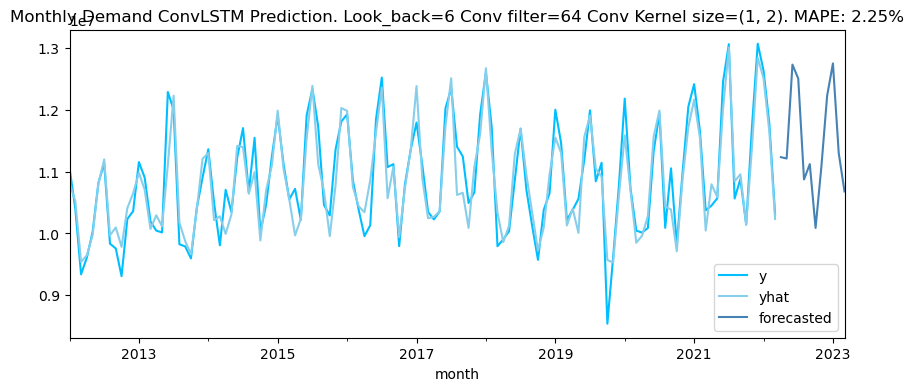

In [512]:
# Calculate MAPE:
ConvLSTM_predicted = model.predict(X_train, verbose=0)
ConvLSTM_predicted = np.reshape(scaler.inverse_transform(ConvLSTM_predicted), (len(ConvLSTM_predicted)))

df_ = pd.DataFrame()
df_['y'] = np.reshape(scaler.inverse_transform(np.reshape(y_train, (1, len(y_train)))), (len(y_train)))
df_['yhat'] = ConvLSTM_predicted
df_.index = df_mdemand.index[:df_mdemand.shape[0]-look_back]
df_.reset_index(inplace=True)
MAPE_CNN = mean_absolute_percentage_error(df_.y, df_.yhat) * 100

# forecast next "future_steps" months
forecasted_values = []
for idx in range(0, future_steps, 1):
    i = len(data)
    slice = [j for j in range(i-look_back,i)]
    # gather input and output parts of the pattern
    input_sequence = data[slice, :][::-1]
    #(X_train.shape[0], n_seq, 1, n_steps, n_features)
    input_sequence = np.reshape(input_sequence, (1, n_seq, 1, n_steps, n_features))
    
    forecasted_value = model.predict(input_sequence, verbose=0)
    forecasted_values.append(forecasted_value[0][0])
        
    data = np.append(data, forecasted_value, axis=0)

forecasted_values = list(scaler.inverse_transform([forecasted_values])[0])

# Build dataframe for plotting
ftr =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
ftr.columns = ['month']
ftr.reset_index(drop=True, inplace=True)
lst = ([None]*df_.shape[0])
lst.extend(forecasted_values)
ftr['forecasted'] = lst

# Plot
df_plot=ftr.merge(df_, on='month', how='left')
plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['y', 'yhat', 'forecasted']
    , right_feat_lst=[]
    , title="Monthly Demand ConvLSTM Prediction. Look_back=" + str(look_back) + " Conv filter=" + str(conv_filter) +\
        " Conv Kernel size=" + str(conv_kernel_size) + ". MAPE: " +\
        str(round(MAPE_CNN, 2)) + '%', xposition=[], yposition=[]
    , fig_size=[10, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

#### Cross Validation

In [507]:
# Model
n_features = 1 # Univariate forcasting
look_back = 6 #12 #6
n_seq = 3 #6 #3
n_steps = 2
conv_filter = 64 # number of features to extract
conv_kernel_size = (1, 2) #dimensions of the convolution window.
hidden_nodes = 48 #48
output_nodes = 1
epochs = 1000
batch_size = 32 # when you reduce this value, the time increases, because the batch size is a hyperparameter of gradient descent 
# that controls the number of training samples to work through before the model’s internal parameters are updated.
future_steps = 6

X, y, input_seq_for_test, slice = preprocess_LSTM(data, look_back=look_back)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
X = np.array(X)
X = np.reshape(X, (X.shape[0], n_seq, 1, n_steps, n_features))
y = np.array(y)

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=conv_filter, kernel_size=conv_kernel_size, activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
# Adam version of stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# Cross Validation
#run the model on each of the time series splits
n_crossvals = 5
max_test_size = 12
print("Monthly Demand ConvLSTM Prediction. Look_back=" + str(look_back) + " Conv filter=" + str(conv_filter) +\
        " Conv Kernel size=" + str(conv_kernel_size) + " n_seq " + str(n_seq) + " n_steps " + str(n_steps)+\
        " epochs: " + str(epochs) + " max test size=" + str(max_test_size))
# Used to limit the size of the test set. Defaults to n_samples // (n_splits + 1), which is the maximum allowed
tscv = TimeSeriesSplit(n_splits=n_crossvals, test_size=max_test_size)
# initalize lists to capture the output
predictions = []
actuals = []
k_fold = 0
for train, test in tscv.split(X, y):
    #fit the model
    model.fit(X[train], y[train], epochs=epochs, verbose=0)
    
    #make predictions
    test_predicted = model.predict(X[test], verbose=0)
    test_predicted = np.reshape(scaler.inverse_transform(test_predicted), (len(test_predicted)))

    #save the results in a list
    predictions.append(test_predicted)
    #actual = scaler.inverse_transform(y[test].copy())
    actual = np.reshape(scaler.inverse_transform(np.reshape(y[test], (1, len(y[test])))), (len(y[test])))
    print('MAPE Parcial K-Fold [', k_fold, ']:', round(mean_absolute_percentage_error(actual.flatten()
                                                    , test_predicted.flatten()) * 100, 2), '%')
    actuals.append(actual)
    k_fold+=1
        
predictions = np.array(predictions)
actuals = np.array(actuals)
mape = mean_absolute_percentage_error(actuals.flatten(), predictions.flatten()) * 100
print('MAPE K-fold:', round(mape, 2), '%')

Monthly Demand ConvLSTM Prediction. Look_back=6 Conv filter=64 Conv Kernel size=(1, 2) n_seq 3 n_steps 2 epochs: 1000 max test size=12
MAPE Parcial K-Fold [ 0 ]: 3.74 %
MAPE Parcial K-Fold [ 1 ]: 4.39 %
MAPE Parcial K-Fold [ 2 ]: 6.89 %
MAPE Parcial K-Fold [ 3 ]: 7.58 %
MAPE Parcial K-Fold [ 4 ]: 5.57 %
MAPE K-fold: 5.63 %


# Understanding np.reshape

In [475]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
#X, y = split_sequence(raw_seq, n_steps)
raw_seq = np.array(raw_seq).reshape((len(raw_seq), 1))
X, y, input_seq_for_test, slice = preprocess_LSTM(raw_seq, look_back=n_steps)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
X=np.array(X)
n_features = 1
n_seq = 2
n_steps = 2
x = X.reshape((X.shape[0], n_seq, n_steps, n_features))

In [476]:
X

array([[40, 30, 20, 10],
       [50, 40, 30, 20],
       [60, 50, 40, 30],
       [70, 60, 50, 40],
       [80, 70, 60, 50]])

In [458]:
x[:1]

array([[[[40],
         [30]],

        [[20],
         [10]]]])

In [493]:
# Data
df_mdemand = df_monthly_demand.copy()
sequence = df_mdemand.month
print(sequence[:5])
print(sequence.shape)
np.array(sequence).reshape((len(sequence), 1))[:5]

0   2012-01-01
1   2012-02-01
2   2012-03-01
3   2012-04-01
4   2012-05-01
Name: month, dtype: datetime64[ns]
(129,)


array([['2012-01-01T00:00:00.000000000'],
       ['2012-02-01T00:00:00.000000000'],
       ['2012-03-01T00:00:00.000000000'],
       ['2012-04-01T00:00:00.000000000'],
       ['2012-05-01T00:00:00.000000000']], dtype='datetime64[ns]')

In [494]:
look_back = 12
X, y, input_seq_for_test, slice = preprocess_LSTM(np.array(sequence).reshape((len(sequence), 1)), look_back=look_back)
X = np.array(X)
print(X.shape)
X[:2]

(117, 12)


array([['2012-12-01T00:00:00.000000000', '2012-11-01T00:00:00.000000000',
        '2012-10-01T00:00:00.000000000', '2012-09-01T00:00:00.000000000',
        '2012-08-01T00:00:00.000000000', '2012-07-01T00:00:00.000000000',
        '2012-06-01T00:00:00.000000000', '2012-05-01T00:00:00.000000000',
        '2012-04-01T00:00:00.000000000', '2012-03-01T00:00:00.000000000',
        '2012-02-01T00:00:00.000000000', '2012-01-01T00:00:00.000000000'],
       ['2013-01-01T00:00:00.000000000', '2012-12-01T00:00:00.000000000',
        '2012-11-01T00:00:00.000000000', '2012-10-01T00:00:00.000000000',
        '2012-09-01T00:00:00.000000000', '2012-08-01T00:00:00.000000000',
        '2012-07-01T00:00:00.000000000', '2012-06-01T00:00:00.000000000',
        '2012-05-01T00:00:00.000000000', '2012-04-01T00:00:00.000000000',
        '2012-03-01T00:00:00.000000000', '2012-02-01T00:00:00.000000000']],
      dtype='datetime64[ns]')

In [498]:
#[samples, subsequences, timesteps, features]
X.reshape((X.shape[0]), 6, 1, 2, 1)[:1]

array([[[[['2012-12-01T00:00:00.000000000'],
          ['2012-11-01T00:00:00.000000000']]],


        [[['2012-10-01T00:00:00.000000000'],
          ['2012-09-01T00:00:00.000000000']]],


        [[['2012-08-01T00:00:00.000000000'],
          ['2012-07-01T00:00:00.000000000']]],


        [[['2012-06-01T00:00:00.000000000'],
          ['2012-05-01T00:00:00.000000000']]],


        [[['2012-04-01T00:00:00.000000000'],
          ['2012-03-01T00:00:00.000000000']]],


        [[['2012-02-01T00:00:00.000000000'],
          ['2012-01-01T00:00:00.000000000']]]]], dtype='datetime64[ns]')

# SVM
https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/3-SVR/README.md

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [620]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.0.


In [633]:
# Data
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# For the SVR, you transform the input data to be of the form [batch, timesteps]
look_back = 12
X, y, input_seq_for_test, slice = preprocess_LSTM(data, look_back=look_back)
x_train = np.array(X)
y_train = np.array(y)

# model
# Scikit internally uses numpy to generate random numbers so doing only random.seed will not effect the behaviour of numpy 
# which is still random.
np.random.seed(786)
model = SVR(kernel='rbf', gamma=0.5, C=10, epsilon = 0.08)
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)

# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1,1))
y_train = scaler.inverse_transform(y_train.reshape(-1,1))

df_ = pd.DataFrame()
df_['y'] = y_train.reshape(-1, y_train.shape[0])[0]
df_['yhat'] = y_train_pred.reshape(-1, y_train_pred.shape[0])[0]
df_.index = df_mdemand.index[:df_mdemand.shape[0]-look_back]
df_.reset_index(inplace=True)
MAPE_SVM = round(mean_absolute_percentage_error(df_.y, df_.yhat) * 100, 2)

print('MAPE for training data: ', MAPE_SVM, '%')


MAPE for training data:  2.77 %


nan

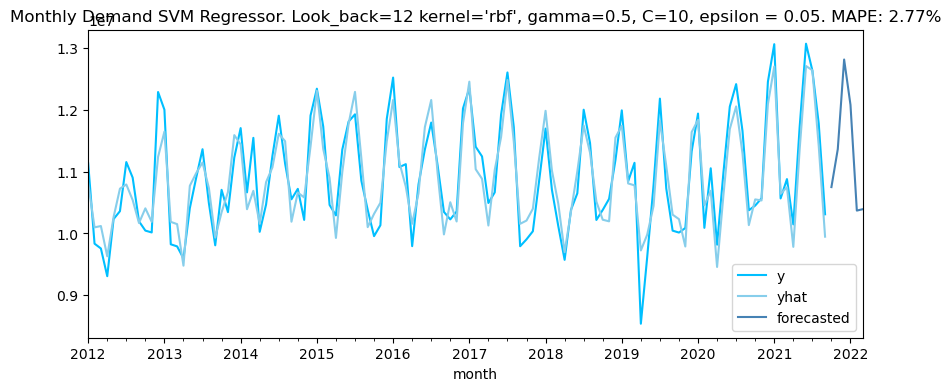

In [636]:
# forecast next "future_steps" months
future_steps = 6
forecasted_values = []
for idx in range(0, future_steps, 1):
    i = len(data)
    slice = [j for j in range(i-look_back,i)]
    # gather input and output parts of the pattern
    input_sequence = data[slice, :][::-1]
    input_sequence = input_sequence.reshape(-1, input_sequence.shape[0])
    
    forecasted_value = model.predict(input_sequence)
    #forecasted_values.append(forecasted_value[0])
    forecasted_values.append(forecasted_value[0])
        
    data = np.append(data, forecasted_value.reshape(-1, 1), axis=0)

forecasted_values = list(scaler.inverse_transform([forecasted_values])[0])

# Build dataframe for plotting
ftr =  (pd.date_range(df_.month.min(), df_.month.max()+relativedelta(months=future_steps), freq='MS')).to_frame()
ftr.columns = ['month']
ftr.reset_index(drop=True, inplace=True)
lst = ([None]*df_.shape[0])
lst.extend(forecasted_values)
ftr['forecasted'] = lst

# Plot
df_plot=ftr.merge(df_, on='month', how='left')
plot_df(df_plot, time_since=df_plot.month.min(), time_until=df_plot.month.max(), time_col='month'
    , left_feat_lst=['y', 'yhat', 'forecasted']
    , right_feat_lst=[]
    , title="Monthly Demand SVM Regressor. Look_back=" + str(look_back) + " kernel='rbf', gamma=0.5, C=10, epsilon = 0.08. MAPE: " +\
        str(round(MAPE_SVM, 2)) + '%', xposition=[], yposition=[]
    , fig_size=[10, 4], return_df=False, left_feat_markers=None, right_feat_markers=None, xlim=None, ylim=None, texts=None)

#### Grid Search
https://www.projectpro.io/recipes/find-optimal-parameters-using-gridsearchcv#mcetoc_1g1istqfd9

In [1]:
df_mdemand = df_monthly_demand.copy()
df_mdemand.set_index('month', inplace=True)
# Data Scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_mdemand)
data = scaler.transform(df_mdemand)

# For the SVR, you transform the input data to be of the form [batch, timesteps]
look_back = 12
n_features = 1
# preprocess data:
data_ = np.array(data)[:, 0]
X_train = []
y_train = []
for i in range(data_.shape[0]-look_back):
    slice = [j for j in range(i,look_back+i)][::-1]
    x = data_[i:look_back+i][::-1]
    y = data_[look_back+i]
    X_train.append(list(x))
    y_train.append(y)    
if type(X_train) == list:
    X_train = np.array(X_train)
X_train = np.array(X_train)
y_train = np.array(y_train)

# model
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid'], 'epsilon':[0.08, 0.1, 1.01]}

grid = GridSearchCV(SVR(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
print('Best Estimator:', grid.best_estimator_)
print('Best Params:', grid.best_params_)

NameError: name 'df_monthly_demand' is not defined

In [ ]:
bts_sup = timeseries_to_supervised(bts,1)
bts_sup = bts_sup.iloc[1:,:]   # delete the line because x0 don't have antecedant
train, test = split_data(bts_sup)

# sacling data
scaler_in = MinMaxScaler()  #  for inputs
scaler_out = MinMaxScaler()  # for outputs

X_train = scaler_in.fit_transform(train[:,0].reshape(-1,1))
y_train = scaler_out.fit_transform(train[:,1].reshape(-1,1))

X_test = scaler_in.transform(test[:,0].reshape(-1,1))
y_test = scaler_out.transform(test[:,1].reshape(-1,1))


param_grid = {"C": np.linspace(10**(-2),10**3,100),
             'gamma': np.linspace(0.0001,1,20)}

mod = SVR(epsilon = 0.1,kernel='rbf')
#svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
#svr_lin = SVR(kernel="linear", C=100, gamma="auto") # lineal model
#svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1) # polinomial model
model = GridSearchCV(estimator = mod, param_grid = param_grid,
                                   scoring = "neg_mean_squared_error",verbose = 0)

best_model = model.fit(X_train, y_train.ravel())

#prediction
predicted_tr = model.predict(X_train)
predicted_te = model.predict(X_test)

# inverse_transform because prediction is done on scaled inputs
predicted_tr = scaler_out.inverse_transform(predicted_tr.reshape(-1,1))
predicted_te = scaler_out.inverse_transform(predicted_te.reshape(-1,1))

#plot
forcast = np.concatenate((predicted_tr,predicted_te))
real = np.concatenate((train[:,1],test[:,1]))
plt.plot(real, color = 'blue', label = 'Real Erlangs')
plt.plot(forcast,"--", linewidth=2,color = 'red', label = 'Predicted Erlangs')
plt.title('Erlangs Prediction--'+data_set.columns[choice])
plt.xlabel('Time')
plt.ylabel('Erlangs')
plt.legend()
plt.show()


#error
print("MSE: ", mse(real,forcast), " R2: ", r2_score(real,forcast))
print(best_model.best_params_)